In [825]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [826]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [827]:
# def getRand(r1, r2, num):
#     return (r1 - r2) * torch.rand(num, 1) + r2

In [828]:
# def gen_data(num_data):

#     x = getRand(-3, 3, num_data)
#     y = getRand(-3, 3, num_data)
#     data_fn = lambda x, y: (x**2+y-11)**2+(x+y**2-7)**2
#     latent_fn = data_fn(x, y)
#     z = latent_fn.long().squeeze()
#     # print(z)
#     for i in range(len(z)):
#         if z[i] > 160:
#             z[i] = 1
#         else:
#             z[i] = 0
#     return torch.cat((x,y),dim=1), z, data_fn

# train_x, train_y, genfn = gen_data(100)
# plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

In [829]:
def get_first_N_points(num):
    with open("./trainx.txt","r") as x:
        data = eval(x.read())
    train_x = torch.tensor(data)[0:num,:]
    with open("./trainy.txt","r") as y:
        data = eval(y.read())
    train_y = torch.tensor(data)[0:num]
    return train_x, train_y

# genfn = lambda x, y: (x**2+y-11)**2+(x+y**2-7)**2
'''Change the num below to change the ↓ number of points available to the model'''
train_x, train_y = get_first_N_points(100)

#This is what the model actually sees
def genfn(x,y):
    result = (x**2+y-11)**2+(x+y**2-7)**2
    for i in range(len(result)):
        for j in range(len(result[0])):
            if result[i][j] > 160:
                result[i][j] = 1
            else:
                result[i][j] = 0
    return result

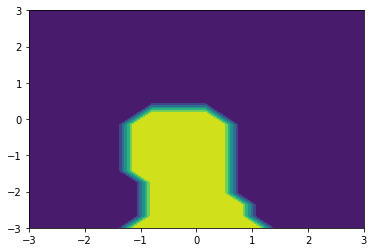

In [830]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [831]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us

likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [832]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if (i+1) % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 5/100 - Loss: 4.909   lengthscale: 0.909   noise: 0.711
Iter 10/100 - Loss: 4.439   lengthscale: 1.168   noise: 0.764
Iter 15/100 - Loss: 4.245   lengthscale: 1.322   noise: 0.821
Iter 20/100 - Loss: 4.152   lengthscale: 1.365   noise: 0.869
Iter 25/100 - Loss: 4.099   lengthscale: 1.352   noise: 0.905
Iter 30/100 - Loss: 4.064   lengthscale: 1.343   noise: 0.927
Iter 35/100 - Loss: 4.032   lengthscale: 1.354   noise: 0.927
Iter 40/100 - Loss: 4.006   lengthscale: 1.352   noise: 0.901
Iter 45/100 - Loss: 3.981   lengthscale: 1.312   noise: 0.846
Iter 50/100 - Loss: 3.959   lengthscale: 1.248   noise: 0.767
Iter 55/100 - Loss: 3.939   lengthscale: 1.192   noise: 0.674
Iter 60/100 - Loss: 3.922   lengthscale: 1.156   noise: 0.577
Iter 65/100 - Loss: 3.909   lengthscale: 1.130   noise: 0.491
Iter 70/100 - Loss: 3.899   lengthscale: 1.103   noise: 0.423
Iter 75/100 - Loss: 3.892   lengthscale: 1.080   noise: 0.376
Iter 80/100 - Loss: 3.885   lengthscale: 1.069   noise: 0.348
Iter 85/1

In [833]:
def smooth_mask(x, a, eps=2e-3):
    """Returns 0ish for x < a and 1ish for x > a"""
    return torch.nn.Sigmoid()((x - a) / eps)

In [834]:
def _estimate_probabilities_of_satisfaction_at_points(points, num_samples):
    probabilities = torch.zeros((points.shape[0:2]))
    print(f"init prob shape: {probabilities.shape}")
    for i in range(len(points)):
        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            test_dist = model(points[i]) # Calculate posterior
            pred_means = test_dist.loc
        pred_samples = test_dist.sample(torch.Size((num_samples,))).exp()
        # print(f"pred_samples shape: {pred_samples.shape}")
        # print(f"pred_samples sum shape: {pred_samples.sum(-2, keepdim=True).shape}")
        # probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        prob_of_one_point = (pred_samples / pred_samples.sum(-2, keepdim=True))[:,1,:].mean(0)
        # torch.cat((probabilities, prob_of_one_point))
        probabilities[i] = prob_of_one_point
        print(f"prob_of_one_point shape: {prob_of_one_point.shape}")
        print(f"prob shape: {probabilities.shape}")
    """Estimate the probability of satisfying the given constraints."""
    # posterior = self.model.posterior(X=points)
    # mus, sigma2s = posterior.mean, posterior.variance
    # dist = torch.distributions.normal.Normal(mus, sigma2s.sqrt())
    # norm_cdf = dist.cdf(self._thresholds)
    # probs = torch.ones(points.shape[:-1]).to(points)
    # for i, (direction, _) in enumerate(self.constraints):
    #     probs = probs * (
    #         norm_cdf[..., i] if direction == "lt" else 1 - norm_cdf[..., i]
    #     )
    
    return probabilities

In [835]:
from botorch.utils.sampling import sample_hypersphere
                            # in bound    out        out       out
sample_point = torch.tensor([[[0, -3]],[[-3, -3]],[[3, 3]],[[1, 3]]])
print(f"sample point shape: {sample_point.shape}")
def generate_ball_of_points(num_samples, radius, device=None, dtype=torch.double):
        tkwargs = {"device": device, "dtype": dtype}
        z = sample_hypersphere(d=sample_point.shape[-1], n=num_samples, qmc=True, **tkwargs) # Not using self.dim
        r = torch.rand(num_samples, 1, **tkwargs) ** (1 / sample_point.dim())
        return radius * r * z

'''
To be resolved:
why is .dim not working?
'''

#Generate 24 samples with radius of 0.5
ball_intermediate = generate_ball_of_points(24, 0.5, device=None, dtype=torch.double)
print(f"init ball shape: {ball_intermediate.shape}")
# print(init_ball + sample_point)
ball_of_points = (sample_point + ball_intermediate).float() # Cast to dtype fp32

# print(ball)
print(f"ball of points shape: {ball_of_points.shape}")


# test_dist = model(ball_of_points)
# print(test_dist.sample())

sample point shape: torch.Size([4, 1, 2])
init ball shape: torch.Size([24, 2])
ball of points shape: torch.Size([4, 24, 2])


In [836]:
domain_mask = smooth_mask(
            ball_of_points, torch.tensor([-3, -3]), torch.tensor([3, 3])
        ).prod(dim=-1)
print(domain_mask.shape)
print(domain_mask)

torch.Size([4, 24])
tensor([[0.3964, 0.3533, 0.3559, 0.3671, 0.3704, 0.3466, 0.3932, 0.3522, 0.3809,
         0.3486, 0.3589, 0.3556, 0.3972, 0.3347, 0.3697, 0.3711, 0.3964, 0.3435,
         0.3692, 0.3613, 0.3893, 0.3353, 0.3671, 0.3453],
        [0.2739, 0.2406, 0.2348, 0.2595, 0.2551, 0.2296, 0.2680, 0.2412, 0.2667,
         0.2380, 0.2366, 0.2495, 0.2760, 0.2229, 0.2486, 0.2584, 0.2796, 0.2267,
         0.2501, 0.2505, 0.2732, 0.2231, 0.2493, 0.2393],
        [0.7925, 0.7687, 0.7638, 0.7823, 0.7795, 0.7599, 0.7883, 0.7691, 0.7877,
         0.7666, 0.7652, 0.7750, 0.7939, 0.7544, 0.7746, 0.7818, 0.7963, 0.7575,
         0.7758, 0.7761, 0.7921, 0.7546, 0.7752, 0.7674],
        [0.7149, 0.6896, 0.6764, 0.7117, 0.7022, 0.6741, 0.7074, 0.6914, 0.7141,
         0.6883, 0.6775, 0.7030, 0.7177, 0.6708, 0.6914, 0.7072, 0.7238, 0.6710,
         0.6945, 0.7009, 0.7187, 0.6706, 0.6946, 0.6930]])


In [837]:
# num_points_in_integral = domain_mask.sum(dim=-1)
# print(num_points_in_integral)

In [838]:
model.eval()
likelihood.eval()

# test_x = test_x[0:5].unsqueeze(0)
# print(test_x.shape)
# print(test_x.dtype)

# with gpytorch.settings.fast_pred_var(), torch.no_grad():
#     test_dist = model(ball_of_points)
#     pred_means = test_dist.loc

# print(test_dist)
# print(pred_means.shape)

# print(test_x)

DirichletClassificationLikelihood(
  (noise_covar): FixedGaussianNoise()
  (second_noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [839]:
# print(test_dist.sample(torch.Size((50,))))

In [840]:
# fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# for i in range(2):
#     im = ax[i].contourf(
#         test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
#     )
#     fig.colorbar(im, ax=ax[i])
#     ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [841]:
# pred_samples = test_dist.sample(torch.Size((36,))).exp()
# probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
# print(ball_of_points.shape)

prob = _estimate_probabilities_of_satisfaction_at_points(ball_of_points, num_samples=50)
                                                                    # This is the num of samples we use to approximate the posterior
                                                                    # Not the same as the num of sample points
# print(f"prob shape: {prob.shape}")


init prob shape: torch.Size([4, 24])
prob_of_one_point shape: torch.Size([24])
prob shape: torch.Size([4, 24])
prob_of_one_point shape: torch.Size([24])
prob shape: torch.Size([4, 24])
prob_of_one_point shape: torch.Size([24])
prob shape: torch.Size([4, 24])
prob_of_one_point shape: torch.Size([24])
prob shape: torch.Size([4, 24])


In [842]:
print(prob)

tensor([[0.9259, 0.9029, 0.9365, 0.7834, 0.9119, 0.9206, 0.9545, 0.8831, 0.8591,
         0.8815, 0.9399, 0.7934, 0.9051, 0.8755, 0.9523, 0.8724, 0.8185, 0.9117,
         0.9442, 0.8666, 0.8524, 0.8796, 0.9382, 0.8085],
        [0.0095, 0.0226, 0.0335, 0.0168, 0.0158, 0.0337, 0.0128, 0.0221, 0.0121,
         0.0241, 0.0333, 0.0204, 0.0087, 0.0364, 0.0221, 0.0147, 0.0084, 0.0362,
         0.0196, 0.0178, 0.0100, 0.0364, 0.0194, 0.0246],
        [0.0411, 0.0133, 0.0108, 0.0313, 0.0237, 0.0086, 0.0323, 0.0140, 0.0366,
         0.0121, 0.0116, 0.0219, 0.0449, 0.0063, 0.0173, 0.0278, 0.0523, 0.0078,
         0.0187, 0.0211, 0.0439, 0.0064, 0.0183, 0.0141],
        [0.0124, 0.0030, 0.0052, 0.0030, 0.0041, 0.0035, 0.0147, 0.0028, 0.0047,
         0.0027, 0.0061, 0.0026, 0.0113, 0.0027, 0.0062, 0.0036, 0.0080, 0.0034,
         0.0051, 0.0030, 0.0064, 0.0027, 0.0045, 0.0024]])


In [843]:
# fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# levels = np.linspace(0, 1.05, 20)
# for i in range(2):
#     im = ax[i].contourf(
#         test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
#     )
#     fig.colorbar(im, ax=ax[i])
#     ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

# print(pred_samples[0][0])
# print(pred_samples[3][0])
# print(pred_samples[:,0,1])
# print(pred_samples[:,0,1].sum()/20)
# print(pred_samples.shape)
# print(pred_samples.sum(-2).shape)
# print(pred_samples.sum(-2, keepdim=True).shape)
# print(probabilities[0])
# print(probabilities.shape)
# print(probabilities)

NameError: name 'pred_means' is not defined

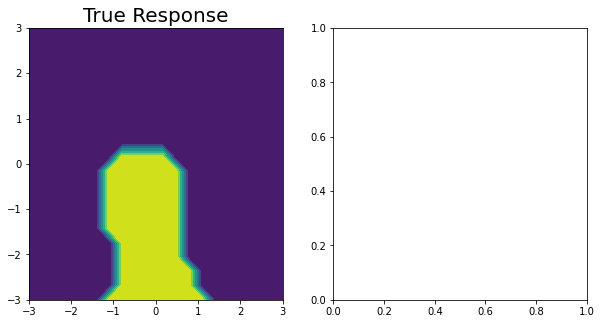

In [844]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)